In [1]:
from dataloader import read_bci_data
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

lr = 1e-3
epochs = 300
train_x, train_y, test_x, test_y = read_bci_data()

# customized Dataset to use DataLoader
# more easy to modify batch size
class BCIDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.from_numpy(data)
        self.label = torch.torch.from_numpy(label).long()

    def __getitem__(self,index):
        return self.data[index],self.label[index]

    def __len__(self):
        return len(self.data)

    
class EEGNet(nn.Module):
    def __init__(self, activation):
        super(EEGNet, self).__init__()
        
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1), padding=(0,25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1,1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        # flatten
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

from functools import reduce
class DeepConvNet(nn.Module):
    def __init__(self, activation, deepconv=[25, 50, 100, 200]):
        super(DeepConvNet, self).__init__()
        
        self.deepconv = deepconv
        self.conv0 = nn.Sequential(
            nn.Conv2d(1, deepconv[0], kernel_size=(1, 5)),
            nn.Conv2d(deepconv[0], deepconv[0], kernel_size=(2,1)),
            nn.BatchNorm2d(deepconv[0], eps=1e-05, momentum=0.1),
            activation(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5)
        )
        
        for idx in range(1, len(deepconv)):
            setattr(self, 'conv'+str(idx), nn.Sequential(
                nn.Conv2d(deepconv[idx-1], deepconv[idx], kernel_size=(1,5)),
                nn.BatchNorm2d(deepconv[idx], eps=1e-05, momentum=0.1),
                activation(),
                nn.MaxPool2d(kernel_size=(1, 2)),
                nn.Dropout(p=0.5)
            ))
        
        flatten_size =  deepconv[-1] * reduce(lambda x,_: round((x-4)/2), deepconv, 750)
        self.classify = nn.Sequential(
            nn.Linear(in_features=flatten_size, out_features=2, bias=True),
        )
    
    def forward(self, x):
        for i in range(len(self.deepconv)):
            x = getattr(self, 'conv'+str(i))(x)
        # flatten
        x = x.view(-1, self.classify[0].in_features)
        x = self.classify(x)
        return x

# Training function
def train(model, train_loader, optimizer, Loss, epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        data, target = data.to(device=device, dtype=torch.float), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()
        # print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()), end='')
    return 100. * correct / len(train_loader.dataset)
    

# Testing function
def test(model, test_loader, Loss, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        data, target = data.to(device=device, dtype=torch.float), target.to(device)
        with torch.no_grad():
            output = model(data)
            test_loss += Loss(output, target).item()
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader)
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))
    # return the avg acc for test set
    return 100. * correct / len(test_loader.dataset)

# plot accuracy curve
def plot_acc_curve(acc_dict, epochs):
    print("\nAccuracy curve: ")
    plt.figure(figsize = (9,6))
    x = []
    for i in range(1, epochs + 1):
        x.append(i)
    for key, acc_list in acc_dict.items():
        plt.plot(x, acc_list, label=key)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.show()


(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


EEGNet 

Accuracy curve: 


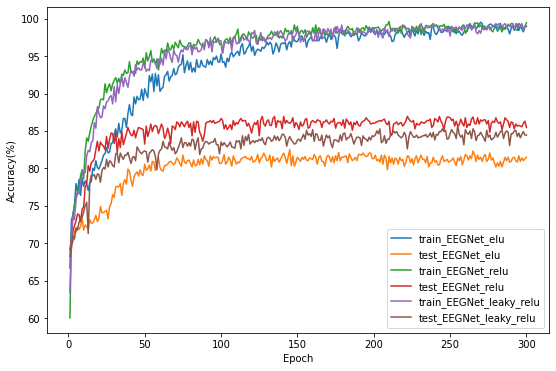

In [2]:
# # Run EGGNet and plot accuracy curve
def EEGNet_result():
    train_set = BCIDataset(data=train_x, label=train_y)
    test_set = BCIDataset(data=test_x, label=test_y)

    train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False, num_workers=2)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    models = {
        "EEGNet_elu" : EEGNet(nn.ELU).to(device),
        "EEGNet_relu" : EEGNet(nn.ReLU).to(device),
        "EEGNet_leaky_relu" : EEGNet(nn.LeakyReLU).to(device),
    }
    
    
    acc_dict = {}
    for key, model in models.items():
        # define loss and optimizer
        Loss = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_acc_list = []  # a list record training set accuracy of every epoch for current model
        test_acc_list = []  # a list record test set accuracy of every epoch for current model
        for epoch in range(1, epochs + 1):
            acc = train(model, train_loader, optimizer, Loss, epoch)
            train_acc_list.append(acc)
            acc = test(model, test_loader, Loss, epoch)
            test_acc_list.append(acc)
        
        train_key = "train_"+key
        test_key = "test_"+key
        acc_dict[train_key] = train_acc_list
        acc_dict[test_key] = test_acc_list
    print("EEGNet ")
    plot_acc_curve(acc_dict, epochs)

EEGNet_result()

DeepConvNet 

Accuracy curve: 


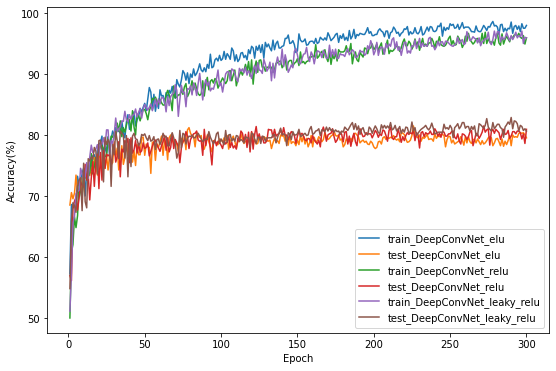

In [3]:
# Run DeepConvNet and plot accuracy curve
def DeepConvNet_result():
    train_set = BCIDataset(data=train_x, label=train_y)
    test_set = BCIDataset(data=test_x, label=test_y)

    train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False, num_workers=2)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    models = {
        "DeepConvNet_elu" : DeepConvNet(nn.ELU).to(device),
        "DeepConvNet_relu" : DeepConvNet(nn.ReLU).to(device),
        "DeepConvNet_leaky_relu" : DeepConvNet(nn.LeakyReLU).to(device),
    }
    
    
    acc_dict = {}  # accuracy dictionary for each model with its accuracy_list
    for key, model in models.items():
        # define loss and optimizer
        Loss = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_acc_list = []  # a list record training set accuracy of every epoch for current model
        test_acc_list = []  # a list record test set accuracy of every epoch for current model
        for epoch in range(1, epochs + 1):
            acc = train(model, train_loader, optimizer, Loss, epoch)
            train_acc_list.append(acc)
            acc = test(model, test_loader, Loss, epoch)
            test_acc_list.append(acc)
        
        train_key = "train_"+key
        test_key = "test_"+key
        acc_dict[train_key] = train_acc_list
        acc_dict[test_key] = test_acc_list
    print("DeepConvNet ")
    plot_acc_curve(acc_dict, epochs)


DeepConvNet_result()

EEGNet vs DeepConvNet 

Accuracy curve: 


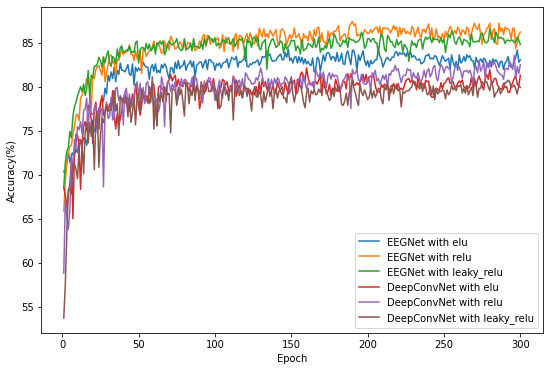

EEGNet with elu  best accuracy:  84.4444
EEGNet with relu  best accuracy:  87.4074
EEGNet with leaky_relu  best accuracy:  86.5741
DeepConvNet with elu  best accuracy:  82.1296
DeepConvNet with relu  best accuracy:  83.5185
DeepConvNet with leaky_relu  best accuracy:  81.1111


In [4]:
# EEGNet vs DeepConvNet
def compare_result():
    train_set = BCIDataset(data=train_x, label=train_y)
    test_set = BCIDataset(data=test_x, label=test_y)

    train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False, num_workers=2)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    models = {
        "EEGNet with elu" : EEGNet(nn.ELU).to(device),
        "EEGNet with relu" : EEGNet(nn.ReLU).to(device),
        "EEGNet with leaky_relu" : EEGNet(nn.LeakyReLU).to(device),
        "DeepConvNet with elu" : DeepConvNet(nn.ELU).to(device),
        "DeepConvNet with relu" : DeepConvNet(nn.ReLU).to(device),
        "DeepConvNet with leaky_relu" : DeepConvNet(nn.LeakyReLU).to(device),
    }
    
    acc_dict = {}  # accuracy dictionary for each model with its accuracy_list
    best_acc_list = {}  # a dictionary record each model's best accuracy from multiple test sets
    
    for key, model in models.items():
        # define loss and optimizer
        Loss = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        test_acc_list = []  # a list record accuracy of every epoch for current model
        for epoch in range(1, epochs + 1):
            train(model, train_loader, optimizer, Loss, epoch)
            acc = test(model, test_loader, Loss, epoch)
            test_acc_list.append(acc)
        acc_dict[key] = test_acc_list
        best_acc_list[key] = max(test_acc_list)
        
        
    print("EEGNet vs DeepConvNet ")
    plot_acc_curve(acc_dict, epochs)
    
    for key, best_acc in best_acc_list.items():
        print(key, " best accuracy: ", np.around(best_acc.item(), 4))

compare_result()

# Result Comparison
對EGGNet來說針對這三種activation function是relu > leaky relu >  elu (針對test set)

對DeepConvNet來說這三種activation function都差不多 (針對test set)

對這兩種網路架構來說，在同樣的參數下（batch size, epochs, learning rate, ...），EGGNet明顯優於DeepConvNet(針對test set)
